# T<sub>2</sub> Hahn Characterization

The purpose of the $T_2$ Hahn Echo experiment is to determine $T_2$ qubit property. 

In this experiment, we would like to get a more precise estimate of the qubit's decay time. $T_2$ represents the amount of time required for the transverse magnetization to fall to approximately 37% ($\frac{1}{e}$) of its initial value.

Since the qubit is exposed to other types of noise (like $T_1$), we are using a $Rx(\pi)$ pulse for decoupling and to solve our inaccuracy for the qubit frequency estimation.

In [1]:
import qiskit
from qiskit_experiments.library.characterization.t2hahn import T2Hahn

The circuit used for the experiment comprises the following:

    1. Rx gate
    2. delay
    3. measurement

The user provides as input a series of delays in seconds. During the delay, we expect the qubit to precess about the z-axis. Because of the echo gate ($Rx(\pi)$) for each echo, the angle after the delay gates will be $\theta_{new} = \theta_{old} + \pi$. After waiting the same delay time, the angle will be approximately $0$ or $\pi$. By varying the extension of the delays, we get a series of decaying measurements. We can draw the graph of the resulting function and can analytically extract the desired values.

In [2]:
qubit = 0
conversion_factor = 1e-6 # our delay will be in micro-sec
delays = list(range(1, 50, 1) )
delays = [float(_) * conversion_factor for _ in delays]
number_of_echoes = 1

# Create a T2Hahn experiment. Print the first circuit as an example
exp1 = T2Hahn(qubit=qubit, delays=delays, num_echoes=number_of_echoes)
print(exp1.circuits()[0])

     ┌─────────┐┌─────────────────┐┌───────┐┌─────────────────┐┌─────────┐┌─┐
  q: ┤ Rx(π/2) ├┤ Delay(1e-06[s]) ├┤ Rx(π) ├┤ Delay(1e-06[s]) ├┤ Rx(π/2) ├┤M├
     └─────────┘└─────────────────┘└───────┘└─────────────────┘└─────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════════════╩═
                                                                           0 


We run the experiment on a simple, simulated backend, created specifically for this experiment's tutorial.

In [3]:
from qiskit_experiments.test.t2hahn_backend import T2HahnBackend

estimated_t2hahn = 20 * conversion_factor
# The behavior of the backend is determined by the following parameters
backend = T2HahnBackend(
    t2hahn=[estimated_t2hahn],
    frequency=[100100],
    initialization_error=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],
)

The resulting graph will have the form:
$f(t) = a \cdot e^{-\frac{t}{T_2}}+ b$
where *t* is the delay and $T_2$ is the decay factor.

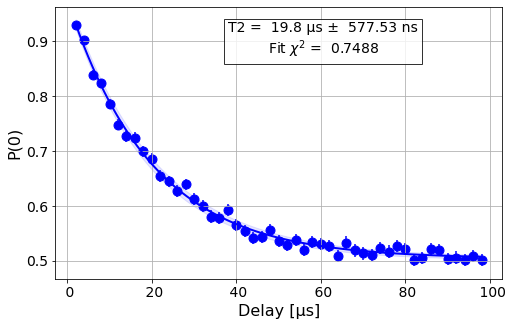

In [4]:
exp1.analysis.set_options(p0=None, plot=True)
expdata1 = exp1.run(backend=backend, shots=2000)
expdata1.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata1.figure(0))

In [5]:
# Print results
for result in expdata1.analysis_results():
    print(result)

DbAnalysisResultV1
- name: @Parameters_T2HahnAnalysis
- value: [4.73150194e-01 5.03648438e-01 1.98283181e-05] ± [5.15456349e-03 3.04084131e-03 5.77525843e-07]
- χ²: 0.7488240853624647
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: T2
- value: 1.982831812408823e-05 ± 5.775258431912853e-07 s
- χ²: 0.7488240853624647
- quality: good
- device_components: ['Q0']
- verified: False


### Providing initial user estimates
The user can provide initial estimates for the parameters to help the analysis process. Because the curve is expected to decay toward $0.5$, the natural choice for parameter $B$ is $0.5$. When there is no $T_2$ error, we would expect that the probability to measure `1` is $100\%$, therefore we will guess that A is $0.5$. In this experiment, `t2hahn` is the parameter of interest. Good estimate for it is the value computed in previous experiments on this qubit or a similar value computed for other qubits.

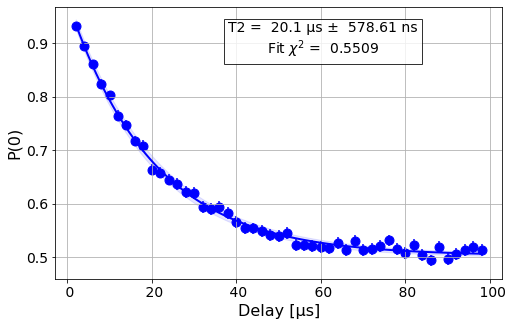

In [6]:
exp_with_p0 = T2Hahn(qubit=qubit, delays=delays, num_echoes=number_of_echoes)
exp_with_p0.analysis.set_options(p0={"amp": 0.5, "tau": estimated_t2hahn, "base": 0.5})
expdata_with_p0 = exp_with_p0.run(backend=backend, shots=2000)
expdata_with_p0.block_for_results()

# Display fit figure
display(expdata_with_p0.figure(0))

In [7]:
# Print results
for result in expdata_with_p0.analysis_results():
    print(result)

DbAnalysisResultV1
- name: @Parameters_T2HahnAnalysis
- value: [4.78978892e-01 5.02410014e-01 2.01190669e-05] ± [5.08967760e-03 3.07896251e-03 5.78613251e-07]
- χ²: 0.5509343873343946
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: T2
- value: 2.0119066897403302e-05 ± 5.786132511852634e-07 s
- χ²: 0.5509343873343946
- quality: good
- device_components: ['Q0']
- verified: False


### Number of echoes
The user can provide the number of echoes that the circuit will perform. This will determine the amount of delay and echo gates. As the number of echoes increases, the total time of the circuit will grow. The echoes decrease the effects of $T_{1}$ noise and frequency inaccuracy estimation. Due to that, the Hahn Echo experiment improves our estimate for $T_{2}$. In the following code, we will compare results of the Hahn experiment with `0` echoes and `4` echoes. In addition, we will add frequency to the qubit and see how the result changes due to that (We can see Rabi Oscillations in the `0` echoes case).
Note, that the provided delay time is the for each delay in the circuit and not the total time.

In [8]:
import numpy as np

qubit2 = 0
# set the desired delays
conversion_factor = 1e-6

# The delays aren't equally spaced due the behavior of exponential decay curve where the change in the result
# in earlier times is larger than later times. In addition, since the total delay is 'delay * 2 * num_of_echoes',
# the construction of the delays for each experiment will be different, such that their total length will be the same.

# Delays for Hahn Echo Experiment with 0 echoes
delays2 = np.append(
                    (np.linspace(1.0, 50.0, num=50)).astype(float),
                    (np.linspace(51, 100.0, num=50)).astype(float),
                )

delays2 = [float(_) * conversion_factor for _ in delays2]

# Delays for Hahn Echo Experiment with 4 echoes
delays3 = np.append(
                    (np.linspace(0.125, 6.25, num=50)).astype(float),
                    (np.linspace(6.375, 12.5, num=50)).astype(float),
                )
delays3 = [float(_) * conversion_factor for _ in delays3]

num_echoes = 4
estimated_t2hahn2 = 20 * conversion_factor

# Create a T2Hahn experiment with 0 echoes
exp2_0echoes = T2Hahn(qubit2, delays2, num_echoes=0)
exp2_0echoes.analysis.set_options(p0={"amp": 0.5, "tau": estimated_t2hahn2, "base": 0.5})
print("The first circuit of hahn echo experiment with 0 echoes:")
print(exp2_0echoes.circuits()[0])

# Create a T2Hahn experiment with 4 echoes. Print the first circuit as an example
exp2_4echoes = T2Hahn(qubit2, delays3, num_echoes=4)
exp2_4echoes.analysis.set_options(p0={"amp": 0.5, "tau": estimated_t2hahn2, "base": 0.5})
print("The first circuit of hahn echo experiment with 4 echoes:")
print(exp2_4echoes.circuits()[0])


The first circuit of hahn echo experiment with 0 echoes:
     ┌─────────┐┌─────────────────┐┌──────────┐┌─┐
  q: ┤ Rx(π/2) ├┤ Delay(1e-06[s]) ├┤ Rx(-π/2) ├┤M├
     └─────────┘└─────────────────┘└──────────┘└╥┘
c: 1/═══════════════════════════════════════════╩═
                                                0 
The first circuit of hahn echo experiment with 4 echoes:
     ┌─────────┐┌────────────────────┐┌───────┐┌────────────────────┐»
  q: ┤ Rx(π/2) ├┤ Delay(1.25e-07[s]) ├┤ Rx(π) ├┤ Delay(1.25e-07[s]) ├»
     └─────────┘└────────────────────┘└───────┘└────────────────────┘»
c: 1/════════════════════════════════════════════════════════════════»
                                                                     »
«     ┌────────────────────┐┌───────┐┌────────────────────┐»
«  q: ┤ Delay(1.25e-07[s]) ├┤ Rx(π) ├┤ Delay(1.25e-07[s]) ├»
«     └────────────────────┘└───────┘└────────────────────┘»
«c: 1/═════════════════════════════════════════════════════»
«                               

Hahn Echoe with 0 echoes:


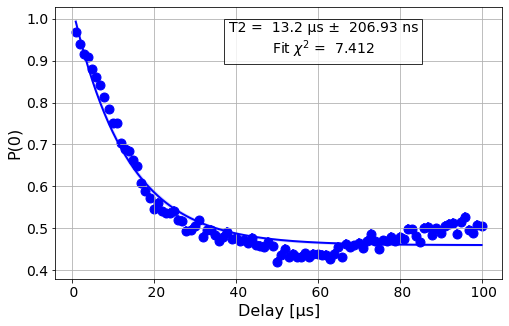

Hahn Echoe with 4 echoes:


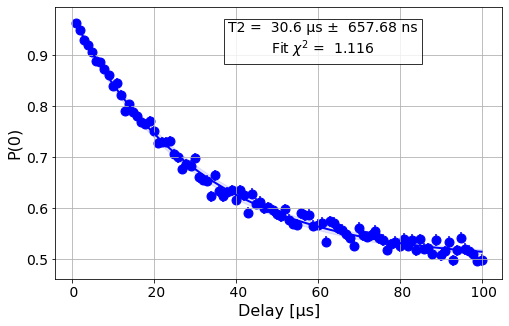

In [9]:
from qiskit_experiments.test.t2hahn_backend import T2HahnBackend

estimated_t2hahn2 = 30 * conversion_factor
# The behavior of the backend is determined by the following parameters
backend2 = T2HahnBackend(
    t2hahn=[estimated_t2hahn2],
    frequency=[50010],
    initialization_error=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],)

# Analysis for Hahn Echo experiemnt with 0 echoes.
expdata2_0echoes = exp2_0echoes.run(backend=backend2, shots=2000)
expdata2_0echoes.block_for_results()  # Wait for job/analysis to finish.

# Analysis for Hahn Echo experiemnt with 4 echoes.
expdata2_4echoes = exp2_4echoes.run(backend=backend2, shots=2000)
expdata2_4echoes.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
print("Hahn Echo with 0 echoes:")
display(expdata2_0echoes.figure(0))
print("Hahn Echo with 4 echoes:")
display(expdata2_4echoes.figure(0))

We see that the estimate $T_2$ is different in the two plots. The mock backend for this experiment used $T_{2} = 30[\mu s]$, which is close to the estimate of the 4 echoes experiment

In [10]:
import qiskit.tools.jupyter
%qiskit_copyright